# Blood donations

In [176]:
import numpy as np 
import pandas as pd

In [280]:
train = pd.read_csv('training-data.csv', index_col=0)

In [281]:
train_np = train.drop(['Made Donation in March 2007'], axis=1)
train_p = train['Made Donation in March 2007']

Add new features to dataset:

In [282]:
months_donated = train.iloc[:,[0,3]].apply(lambda row: row[1] - row[0], axis=1)
train['Average donations per month'] = months_donated / train['Number of Donations']

Add some categorical features:

In [283]:
def quitted(row):
    if row['Months since Last Donation'] > 12:
        if row['Number of Donations'] < 4:
            return 1
        else:
            return 0
        
    else:
        return 0

In [284]:
train['OldBadDonor'] = train['Months since Last Donation'].apply(lambda x: 1 if x >=5 else 0)
train['BadDonor'] = train['Months since Last Donation'].apply(lambda x: 1 if x == 5 else 0)
train['GoodDonor'] = train['Months since Last Donation'].apply(lambda x: 1 if x <= 2 else 0)
train['Quitted'] = train.apply(quitted, axis=1)

In [285]:
train

,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007,Average donations per month,OldBadDonor,BadDonor,GoodDonor,Quitted
619,2,50,12500,98,1,1.920000,0,0,1,0
664,0,13,3250,28,1,2.153846,0,0,1,0
441,1,16,4000,35,1,2.125000,0,0,1,0
160,2,20,5000,45,1,2.150000,0,0,1,0
358,1,24,6000,77,0,3.166667,0,0,1,0
335,4,4,1000,4,0,0.000000,0,0,0,0
47,2,7,1750,14,1,1.714286,0,0,1,0
164,1,12,3000,35,0,2.833333,0,0,1,0
736,5,46,11500,98,1,2.021739,1,1,0,0
436,0,3,750,4,0,1.333333,0,0,1,0


In [286]:
x_train = train.drop(['Made Donation in March 2007'], axis=1)
y_train = train['Made Donation in March 2007']

In [287]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif, chi2

Use `SelectKBest` with ANOVA F-value to select best features to use as predictors

In [288]:
predictors = x_train.columns.tolist()

selector = SelectKBest(f_classif, k=4)
selector.fit(x_train[predictors], y_train)

scores = -1 * np.log10(selector.pvalues_)
scores[scores == np.inf] = 1

In [289]:
best_features = pd.DataFrame(scores.tolist(), index=predictors)
best_features

,0
Months since Last Donation,9.714625
Number of Donations,7.054097
Total Volume Donated (c.c.),7.054097
Months since First Donation,0.197209
Average donations per month,1.247248
OldBadDonor,11.107794
BadDonor,0.410856
GoodDonor,6.199344
Quitted,4.880267


Select best features based on p-value higher than the mean and sort the data frame

In [290]:
bf_mean = best_features.mean().tolist()[0]

bf_overall = best_features.loc[best_features[0] > bf_mean]
bf_overall = bf_overall.sort_values(by=0, ascending=0)
bf_predictors = bf_overall.index.tolist()

Plot the best features (p-value > mean) on a barchart 

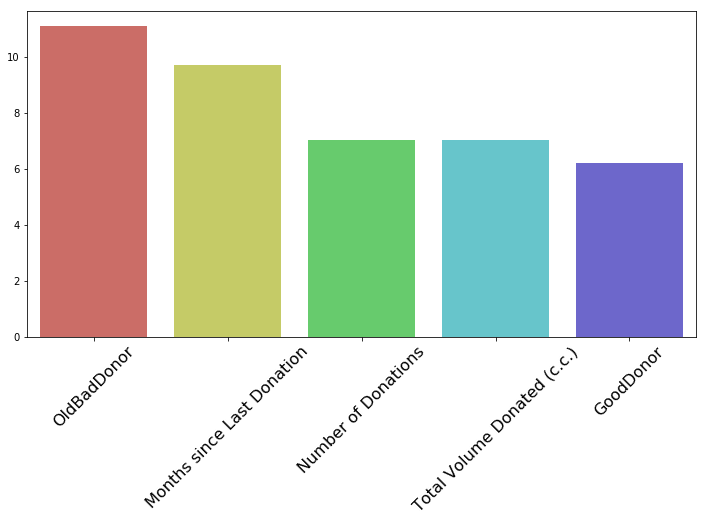

In [293]:
plt.figure(figsize=(12,6))
sns.barplot(list(range(len(bf_predictors))), bf_overall.values.flatten(), palette=sns.color_palette('hls'))
plt.xticks(list(range(len(bf_predictors))), bf_predictors, rotation='45', fontsize=16);

## Logistic regression

In [305]:
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation

alg = LogisticRegression(random_state=1)

scores = cross_validation.cross_val_score(alg, train[bf_predictors], train['Made Donation in March 2007'], cv=3)
scores

array([ 0.75520833,  0.75      ,  0.77604167])

## Decision tree

In [295]:
from sklearn import tree

alg = tree.DecisionTreeClassifier()

scores = cross_validation.cross_val_score(alg, train[bf_predictors], train['Made Donation in March 2007'], cv=3)
scores, np.mean(scores)

(array([ 0.61979167,  0.77083333,  0.77083333]), 0.72048611111111116)

## Random forests

In [311]:
from sklearn.ensemble import RandomForestClassifier


alg = RandomForestClassifier(random_state=1, n_estimators=2, min_samples_split=3, min_samples_leaf=6)

scores = cross_validation.cross_val_score(alg, train[bf_predictors], train['Made Donation in March 2007'], cv=3)
scores, np.mean(scores)

(array([ 0.67708333,  0.78125   ,  0.80208333]), 0.75347222222222232)

## Gradient boosting

In [297]:
from sklearn.ensemble import GradientBoostingClassifier


alg = GradientBoostingClassifier(random_state=1, n_estimators=2, max_depth=2)
scores = cross_validation.cross_val_score(alg, train[bf_predictors], train['Made Donation in March 2007'], cv=3)
scores, np.mean(scores)

(array([ 0.76041667,  0.76041667,  0.76041667]), 0.76041666666666663)

## XGBoost

In [298]:
from xgboost import XGBClassifier

model = XGBClassifier(eta=0.05)
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.05, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [299]:
scores = cross_validation.cross_val_score(model, train[bf_predictors], train['Made Donation in March 2007'], cv=3)
scores, np.mean(scores)

(array([ 0.67708333,  0.76041667,  0.78645833]), 0.74131944444444453)

In [307]:
from sklearn.metrics import log_loss

log_loss(y_train, model.predict(x_train))

5.3967129636944371

In [300]:
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

In [301]:
pipe = Pipeline(steps=[('xgb', XGBClassifier())])

In [249]:
parameters = {
    'xgb__learning_rate': [0.01,0.015,0.025,0.05,0.1],
    'xgb__gamma': [0.05,0.1,0.3,0.5,0.7,0.9,1],
    'xgb__max_depth': [6,7,9],
    'xgb__min_child_weight': [1,3,5,7]
}

In [250]:
est = GridSearchCV(pipe, parameters, n_jobs=-1, verbose=3, cv=3)

In [251]:
est.fit(x_train[bf_predictors], y_train)

Fitting 3 folds for each of 420 candidates, totalling 1260 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 380 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 1260 out of 1260 | elapsed:   39.5s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'xgb__learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1], 'xgb__gamma': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1], 'xgb__max_depth': [6, 7, 9], 'xgb__min_child_weight': [1, 3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=3)

In [252]:
est.grid_scores_

[mean: 0.72396, std: 0.08113, params: {'xgb__gamma': 0.05, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 6, 'xgb__min_child_weight': 1},
 mean: 0.73958, std: 0.06029, params: {'xgb__gamma': 0.05, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 6, 'xgb__min_child_weight': 3},
 mean: 0.73264, std: 0.05038, params: {'xgb__gamma': 0.05, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 6, 'xgb__min_child_weight': 5},
 mean: 0.72917, std: 0.04792, params: {'xgb__gamma': 0.05, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 6, 'xgb__min_child_weight': 7},
 mean: 0.72396, std: 0.08113, params: {'xgb__gamma': 0.05, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 7, 'xgb__min_child_weight': 1},
 mean: 0.73958, std: 0.06029, params: {'xgb__gamma': 0.05, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 7, 'xgb__min_child_weight': 3},
 mean: 0.73264, std: 0.05038, params: {'xgb__gamma': 0.05, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 7, 'xgb__min_child_weight': 5},
 mean: 0.72917, std: 0.04792, params: {'x

In [253]:
est.best_params_

{'xgb__gamma': 0.3,
 'xgb__learning_rate': 0.05,
 'xgb__max_depth': 6,
 'xgb__min_child_weight': 1}

In [314]:
pipe_rf = Pipeline(steps=[('rf', RandomForestClassifier())])

In [315]:
rf_parameters = {
    'rf__n_estimators': [2,3,4,5,6,7,8,9,10],
    'rf__min_samples_split': [2,3,5,7,9,10],
    'rf__min_samples_leaf': [2,3,4,5,6,7,8,9]
}

In [318]:
est_rf = GridSearchCV(pipe_rf, rf_parameters, n_jobs=-1, verbose=3, cv=3)

In [319]:
est_rf.fit(x_train[bf_predictors], y_train)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:   43.4s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'rf__n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'rf__min_samples_split': [2, 3, 5, 7, 9, 10], 'rf__min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=3)

In [ ]:
est_rf.best_params_